# Imports

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.visualization import plot_kde_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO

from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance,PranglePopulationSize,PrangleEpsilon

# Get experimental measurements

In [2]:
myokit_python = ("/tmp/chouston/miniconda3/envs" +
                 "/ion_channel_ABC/bin/python")
args = [myokit_python, "get_measurements.py"]
args.append('ina')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']

# Set limits and generate uniform initial priors

In [3]:
limits = dict(g_Na=(0, 100),
              p1=(0, 100),
              p2=(-100, 0),
              p3=(0, 10),
              p4=(0, 500),
              p5=(-1, 0),
              p6=(0, 1),
              p7=(0, 100),
              q1=(0, 100),
              q2=(0, 10))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialise database

In [4]:
myokit_model = MyokitSimulation('ina')
#myokit_model.sample(prior.rvs())

In [15]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ina.db"))

In [16]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(
                 exp_map=exp,
                 alpha=0.5,
                 delta=0.5,
                 adapt=False),
             population_size=PranglePopulationSize(
                 500, alpha=0.5,
                 adapt=True,
                 mean_cv=0.5,
                 min_population_size=200,
                 max_population_size=5000),
             eps=PrangleEpsilon(100, alpha=0.5))

In [17]:
abc_id = abc.new(db_path, obs)

INFO:Epsilon:initial epsilon is 100
INFO:History:Start <ABCSMC(id=3, start_time=2018-06-25 20:50:47.132094, end_time=None)>


In [18]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=20)

INFO:ABC:t:0 M eps:[100]
INFO:ABC:t:0 N eps:42.247946604188954
INFO:ABC:N population size: 500
INFO:ABC:t:1 M eps:[100.         42.2479466]
INFO:ABC:t:1 N eps:17.971307852035892
INFO:ABC:N population size: 5000
INFO:ABC:t:2 M eps:[100.          42.2479466   17.97130785]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:2 N eps:12.812119272581395
INFO:ABC:N population size: 5000
INFO:ABC:t:3 M eps:[100.          42.2479466   17.97130785  12.81211927]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:3 N eps:10.610362392701237
INFO:ABC:N population size: 5000
INFO:ABC:t:4 M eps:[100.          42.2479466   17.97130785  12.81211927  10.61036239]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:4 N eps:9.51722989487467
INFO:ABC:N population size: 5000
INFO:ABC:t:5 M eps:[100.          42.2479466   17.97130785  12.81211927  10.61036239
   9.51722989]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:5 N eps:8.81858862288553
INFO:ABC:N population size:

In [21]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=10)

INFO:ABC:t:20 M eps:[100.          42.2479466   17.97130785  12.81211927  10.61036239
   9.51722989   8.81858862   8.16935756   7.23051214   6.29428373
   5.4093096    4.61681433   3.95739513   3.43837939   3.04808847
   2.72904063   2.48068799   2.28106311   2.1570371    2.07867848
   2.00997205]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:20 N eps:1.9542450437371615
INFO:ABC:N population size: 5000
INFO:ABC:t:21 M eps:[100.          42.2479466   17.97130785  12.81211927  10.61036239
   9.51722989   8.81858862   8.16935756   7.23051214   6.29428373
   5.4093096    4.61681433   3.95739513   3.43837939   3.04808847
   2.72904063   2.48068799   2.28106311   2.1570371    2.07867848
   2.00997205   1.95424504]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:21 N eps:1.9163089147334822
INFO:ABC:N population size: 5000
INFO:ABC:t:22 M eps:[100.          42.2479466   17.97130785  12.81211927  10.61036239
   9.51722989   8.81858862   8.16935756   7.23051214   6.2942

In [5]:
db_path = 'sqlite:///pyabc-runs/hl-1_ina.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-06-24 09:19:47.020199, end_time=2018-06-24 21:47:51.000864)>,
 <ABCSMC(id=2, start_time=2018-06-25 10:54:29.771252, end_time=2018-06-25 19:39:40.053531)>,
 <ABCSMC(id=3, start_time=2018-06-25 20:50:47.132094, end_time=2018-06-26 13:57:23.723691)>]

In [6]:
history.id = 3

/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


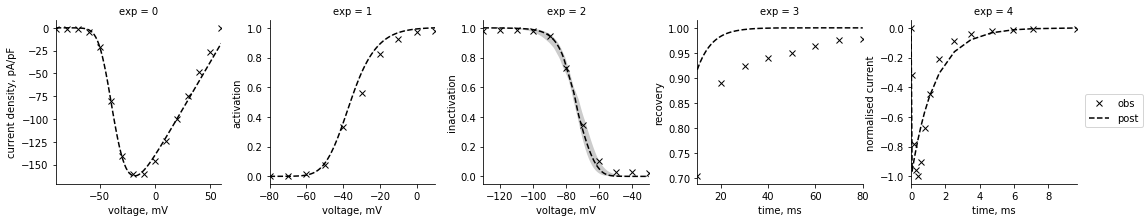

In [7]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'ina', n_samples=10, obs=measurements, original=False)
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
plt.savefig("ina_results.pdf", format='pdf', dpi=1000)

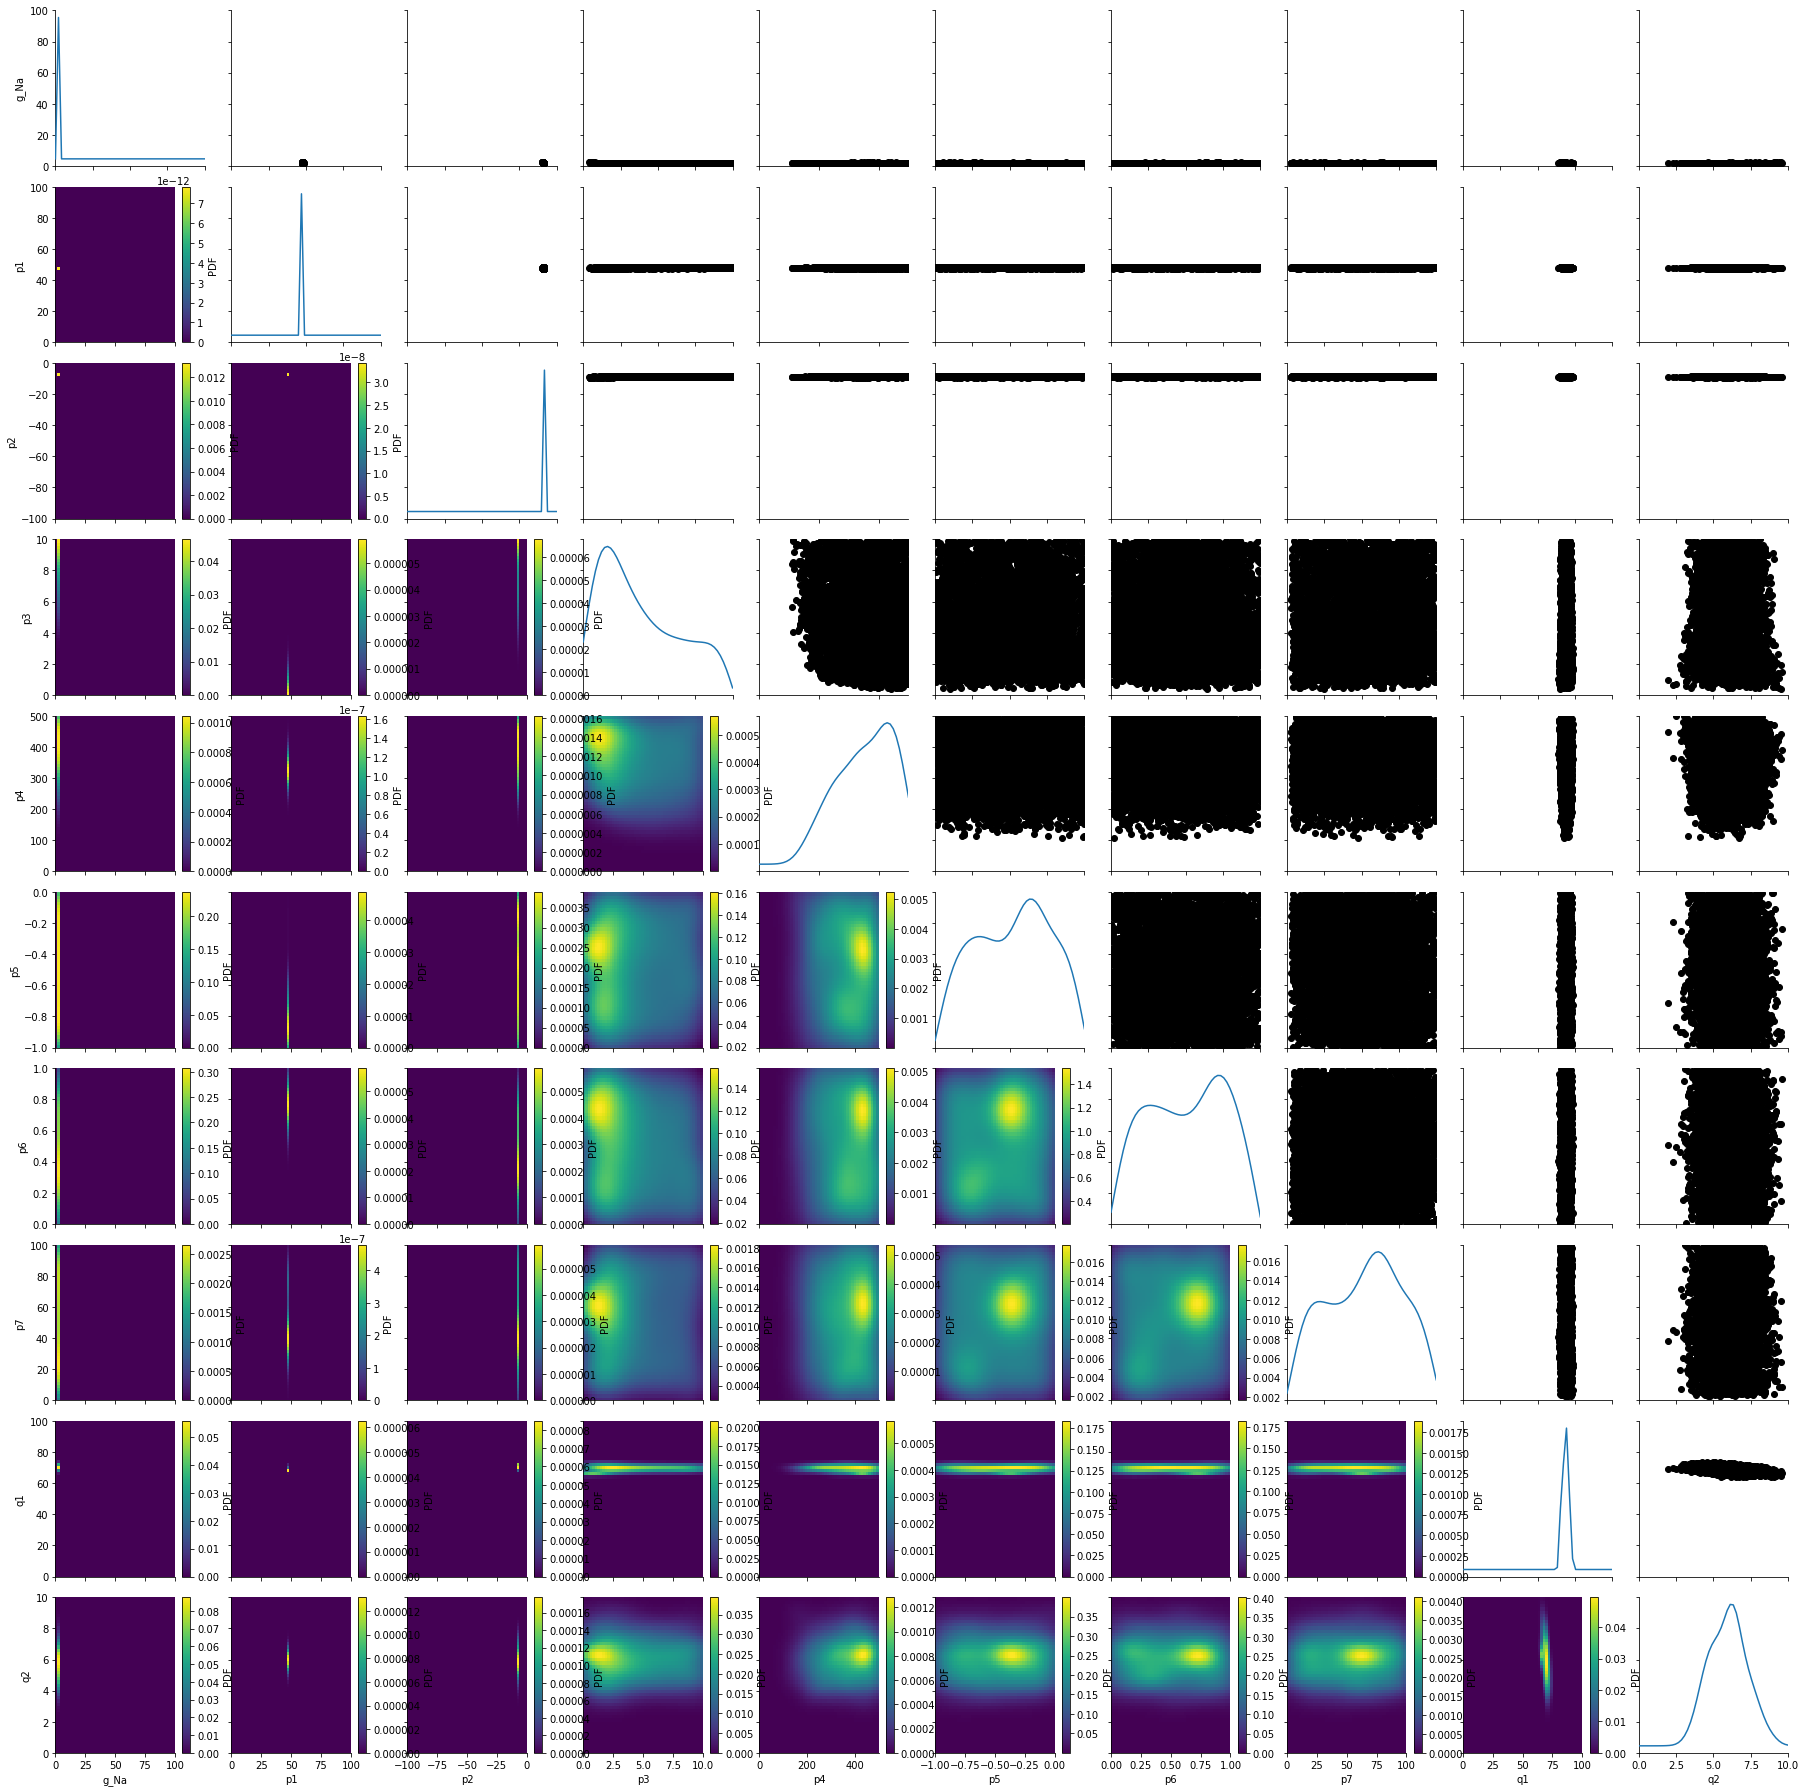

In [23]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [ ]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

In [ ]:
from pyabc_custom import simulate
out = simulate('ina', experiment=0, logvars=['environment.time', 'ina.i_Na'])
fig,ax = plt.subplots(figsize=(13,13))
out.groupby("run").plot(x="environment.time", y="ina.i_Na",ax=ax)